# Stochastic Gradient Descent (GD): Least Squares (LS) Regression

First import the necessary modules and configurations:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import time # Importing to time the different LS approaches

import matplotlib.pyplot as plt # For general plotting
from matplotlib import cm

import numpy as np

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [2]:
# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

# Number of input samples to provide to algorithm
N = 10000

## Generate Synthetic Training Dataset

Generate a training dataset, $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)}) \}_{i=1}^N$, with $N=1000$ examples of input $\mathbf{x} \in \mathbb{R}^n$ and output $y \in \mathbb{R}$ pairs and assume a linear regression model as we did in the [Batch GD example](ls_regression_batch_gd.ipynb):

\begin{equation*}
\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \boldsymbol{\epsilon}
\end{equation*}

Where $\mathbf{y} \in \mathbb{R}^N$ is the target vector, $\mathbf{X} \in \mathbb{R}^{N \times (n+1)}$ the <b>design matrix</b> and $\boldsymbol{\epsilon} \in \mathbb{R}^N$ is the vector of error terms. Recall that the model parameters $\boldsymbol{\theta}^\intercal = [w_0, \mathbf{w}^\intercal] \in \mathbb{R}^{n+1}$ consist of the regression coefficients or weights, $\mathbf{w} \in \mathbb{R}^n$, and the bias $w_0 \in \mathbb{R}$.

To finalize our training dataset, we'll set an arbitrary <i>ground truth</i> parameter vector  $\boldsymbol{\theta^*} = \begin{bmatrix} w^*_0 \\ w^*_1 \end{bmatrix} = \begin{bmatrix} 1.4 \\ -0.7 \end{bmatrix}$ for our GD method to derive.

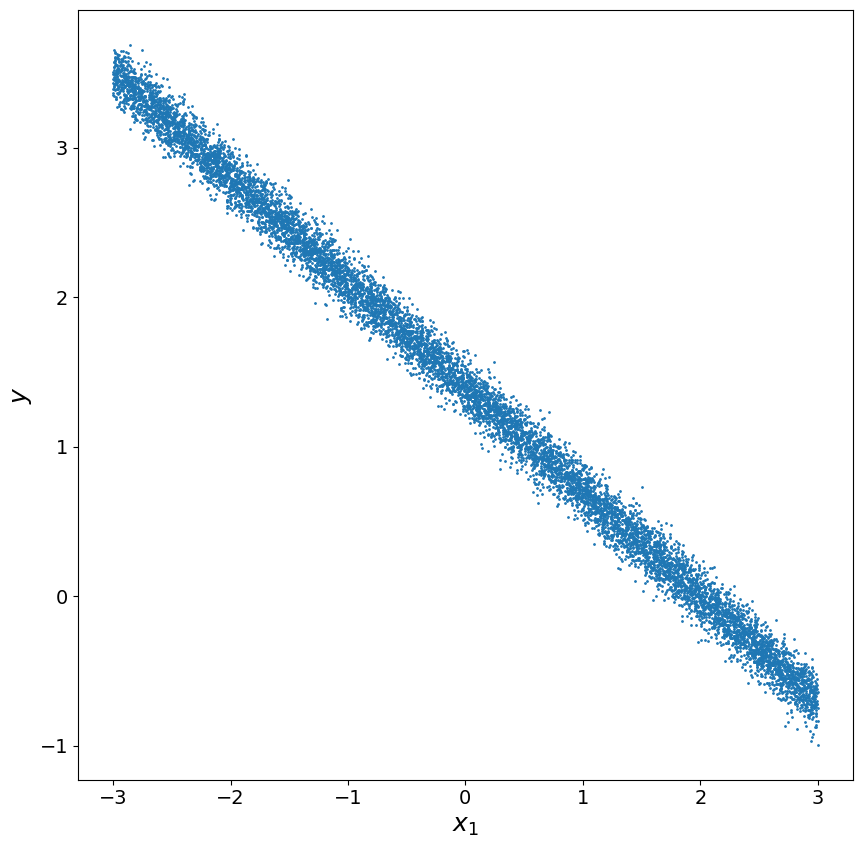

In [3]:
# Generating synthetic data
theta_true = np.array([1.4, -0.7]) # True parameter vector of bias w_0 and regression slope w_1
X = np.random.uniform(-3, 3, N) # Sample uniformly inputs for N-samples dataset
X = np.column_stack((np.ones(N), X))  # Prepend column of ones to create augmented inputs x tilde

# y = X*theta_true + noise
y = X.dot(theta_true) + np.random.normal(0, .1, N)

plt.ioff() # These lines help avoid showing the figure when I don't want to in Jupyter
fig_scatter, ax_scatter = plt.subplots(figsize=(10, 10));
plt.ion() # Re-activate "interactive" mode

ax_scatter.scatter(X[:, 1], y, s=1)
ax_scatter.set_xlabel(r"$x_1$")
ax_scatter.set_ylabel(r"$y$")

display(fig_scatter) # Display as .png

fig_scatter;

## Residual Sum Squared (RSS) Error

Reminder that our loss function $\mathcal{L}(\boldsymbol{\theta})$ is the RSS error:

\begin{equation*}
(\mathbf{X}\boldsymbol{\theta} - \mathbf{y})^\intercal (\mathbf{X}\boldsymbol{\theta} - \mathbf{y})
\end{equation*}

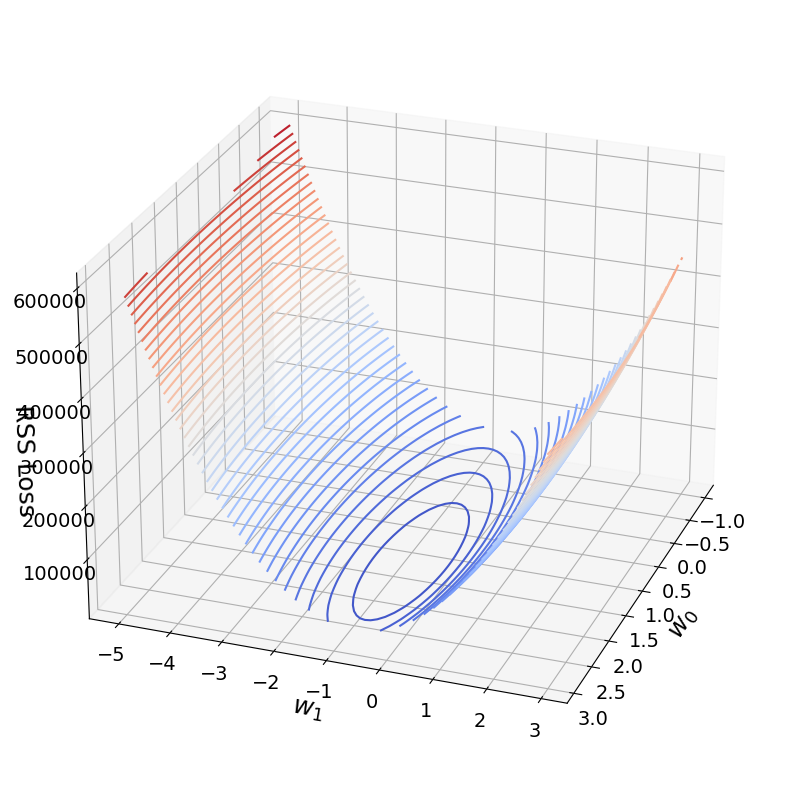

In [4]:
# Plot residual sum squared (RSS) error surface over parameter space
theta0_space = np.arange(-1, 3, 0.1)
theta1_space = np.arange(-5, 3, 0.1)
# Each theta are now coordinate matrices determined by the theta_space
W0, W1 = np.meshgrid(theta0_space, theta1_space)

# Compute RSS error for each weight combination
# Split out into vector form for convenience in reshaping and feeding into the RSS surface plot
rss = np.array([sum((w0 * X[:, 0] + w1 * X[:, 1] - y) ** 2) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
rss = rss.reshape(W0.shape)

plt.ioff() # These lines help avoid showing the figure when I don't want to in Jupyter
fig_surface = plt.figure(figsize=(10, 10))
plt.ion() # Re-activate "interactive" mode

ax_surface = fig_surface.add_subplot(111, projection='3d')
# Plot contour surface of loss function with 50 levels
cs3d = ax_surface.contour3D(W0, W1, rss, 50, cmap=cm.coolwarm)

ax_surface.set_xlabel(r"$w_0$")
ax_surface.set_ylabel(r"$w_1$")
ax_surface.set_zlabel("RSS Loss")
ax_surface.view_init(elev=25., azim=20)

fig_surface

## Analytical Solution

Remember that for a strictly convex function ("bowl" shaped, like the above surface plot), we have a unique global minimum and can thus rearrange the gradient in terms of an analytically optimal parameter vector $\boldsymbol{\theta}_{opt}$:

\begin{equation*}
\boldsymbol{\theta}_{opt} = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^\intercal \mathbf{y}
\end{equation*}

We will use this value to visualize the performance of stochastic GD.

Analytical Theta:  [ 1.39970105 -0.70064569]
MSE:  0.009681585691242967
Time elapsed: 0.0010023117065429688


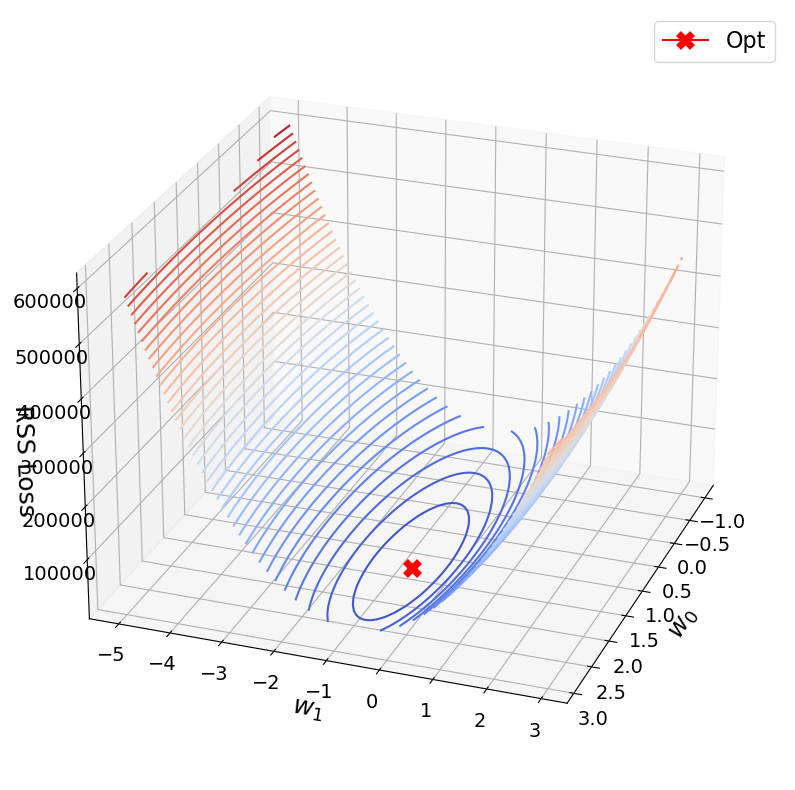

In [5]:
def analytical_solution(X, y):
    # Analytical solution is (X^T*X)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)


start = time.time()
theta_opt = analytical_solution(X, y)
end = time.time()

rss_opt = sum((X.dot(theta_opt) - y) ** 2)
mse_opt = (1 / N) * rss_opt

print("Analytical Theta: ", theta_opt)
print("MSE: ", mse_opt)
print("Time elapsed: {}".format(end-start))

ax_surface.plot(xs=theta_opt[0], ys=theta_opt[1], zs=rss_opt, marker='x', color='r', ms=10, mew=5, label="Opt")
ax_surface.legend()

fig_surface

## Mini-batch/Stochastic Gradient Descent

Our mini-batch GD algorithm is as follows:

1) Initialize $\boldsymbol{\theta}^{(0)}$

2) Batchify dataset: $\mathcal{B}_b \sim \text{Uniform}\{1, \ldots, N\}$

3) Repeat until convergence:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; For each $ b $ in total number of batches:
\begin{align*}
\boldsymbol{\theta}^{(t+1)} & = \boldsymbol{\theta}^{(t)} - \alpha \nabla \mathbb{E}_{i \in \mathcal{B}_b} [\mathcal{L}_i(\boldsymbol{\theta}^{(t)})] \\
& = \boldsymbol{\theta}^{(t)} - \alpha \Bigg(\frac{1}{|\mathcal{B}_b|}\sum_{i \in \mathcal{B}_b} (\boldsymbol{\theta}^{\intercal {(t)}}\mathbf{\tilde{x}}^{(i)} - y^{(i)})\mathbf{\tilde{x}}^{(i)} \Bigg)
\end{align*}

4) When $\mathbf{g}(\boldsymbol{\theta}) \approx \mathbf{0}$, then we have derived $\boldsymbol{\theta}_{SGD}$ using mini-batch/stochastic GD depending on batch size

Remember we want to shuffle uniformly our batches in the GD pipeline, which you can go about in multiple ways. For example:

1) Shuffle the entire dataset <b>before</b> batchifying

2) Batchify the dataset and then <b>shuffle-select</b> batches

3) Shuffle the entire dataset before batchifying <b>AND</b> shuffle-select batches

And so forth. You can shuffle in numerous ways, but option (1) is most common to see and works well in practice. So we'll do that in the following line of code:

In [6]:
shuffled_indices = np.random.permutation(N) # Returns a permutation of indices up to N

# Shuffle row-wise X (i.e. across training examples) and labels using same permuted order
X = X[shuffled_indices]
y = y[shuffled_indices]

One other thing to note is that you should also <b>shuffle</b> your data again <b>after each epoch</b>, else your batch ordering may run the risk of creating a biased gradient estimate. So shuffling after epoches will avoid the possibility of a poorly shuffled, bad batch order. In the toy example below though, I only rely on the one-off dataset shuffle I do in the above cell beforehand, as this works well enough for this problem.

In [7]:
# Starting point from to search for optimal parameters
theta_init = np.array([3, -4])
#theta_init = np.random.randn(2) # Randomly sample from N(0, 1)

# Options for stochastic gradient descent (SGD)
opts = {}
opts['max_epoch'] = 50
opts['alpha'] = 0.05
opts['tolerance'] = 1e-2

opts['batch_size'] = 32
opts['momentum'] = 0.8


# Mean Squared Error (MSE) loss with gradient for optimization:
def lin_reg_loss(theta, X, y):
    # Size of batch
    B = X.shape[0]
    # Linear regression model X * theta
    predictions = X.dot(theta)
    # Residual error (X * theta) - y
    error = predictions - y
    # Loss function is MSE
    loss_f = np.mean(error**2)
    # Partial derivative for GD, X^T * ((X * theta) - y)
    g = (1 / B) * X.T.dot(error)

    return loss_f, g


# Breaks the matrix X and vector y into batches
def batchify(X, y, batch_size):
    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])
        
    return X_batch, y_batch


def gradient_descent(loss_func, theta_init, X, y, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and momentum.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10
    beta = kwargs['momentum'] if 'momentum' in kwargs else 0.9

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size)
    num_batches = len(y_batch)
    print("%d batches of size %d\n" % (num_batches, batch_size))

    theta = theta_init
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        print("epoch %d\n" % epoch)
        
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            mse, gradient = loss_func(theta, X_b, y_b, *args)
            
            # Compute momentum term as exponentially weighted moving average of previous gradients
            # Using the (1 - beta) formulation rather than omitting term; easier to tune alpha
            m_t = beta * m_t + (1 - beta) * gradient
            # Steepest descent update
            theta = theta - alpha * m_t
            
            # Storing the history of the parameters and loss values (MSE)
            trace['loss'].append(mse)
            trace['theta'].append(theta)
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                print("Gradient Descent has converged")
                break

        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break
     
    return theta, trace

start = time.time()
theta_gd, trace = gradient_descent(lin_reg_loss, theta_init, X, y, **opts)
end = time.time()

print("Mini-batch GD Theta: ", theta_gd)
print("MSE: ", trace['loss'][-1])
print("Time elapsed for batch size={}: {}".format(opts['batch_size'], end-start))

# Convert our trace of parameter and loss function values into NumPy "history" arrays:
theta_hist = np.asarray(trace['theta'])
mse_hist = np.array(trace['loss'])

313 batches of size 32

epoch 1

Gradient Descent has converged
Mini-batch GD Theta:  [ 1.40665321 -0.69962028]
MSE:  0.006464487727346808
Time elapsed for batch size=32: 0.008973360061645508


Plot a trajectory of the parameter updates in terms of their RSS values:

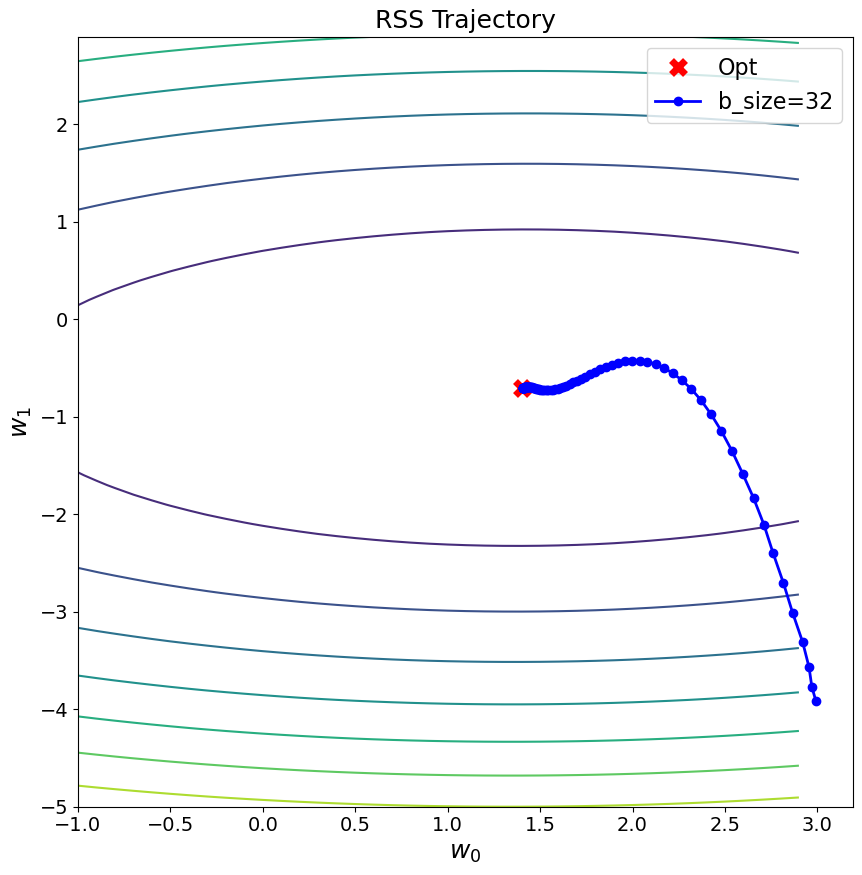

In [8]:
# Creates new figure each time, comment out if you want to use same handle
plt.ioff() # These lines help avoid showing the figure when I don't want to in Jupyter
fig_rss_traj, ax_rss = plt.subplots(figsize=(10, 10));
plt.ion() # Re-activate "interactive" mode

# Parameter trajectory as a contour plot
ax_rss.set_title("RSS Trajectory");
cs = plt.contour(W0, W1, rss);
ax_rss.plot(theta_opt[0], theta_opt[1], 'x', color='r', ms=10, mew=5, label="Opt");

ax_rss.plot(theta_hist[:, 0], theta_hist[:, 1], 'bo-', lw=2, label="b_size={}".format(opts['batch_size']));
ax_rss.legend()

ax_rss.set_xlabel(r"$w_0$")
ax_rss.set_ylabel(r"$w_1$")

fig_rss_traj

Plot the MSE progression over training iterations (epochs), with the horizontal line showing the analytical "optimal" solution:

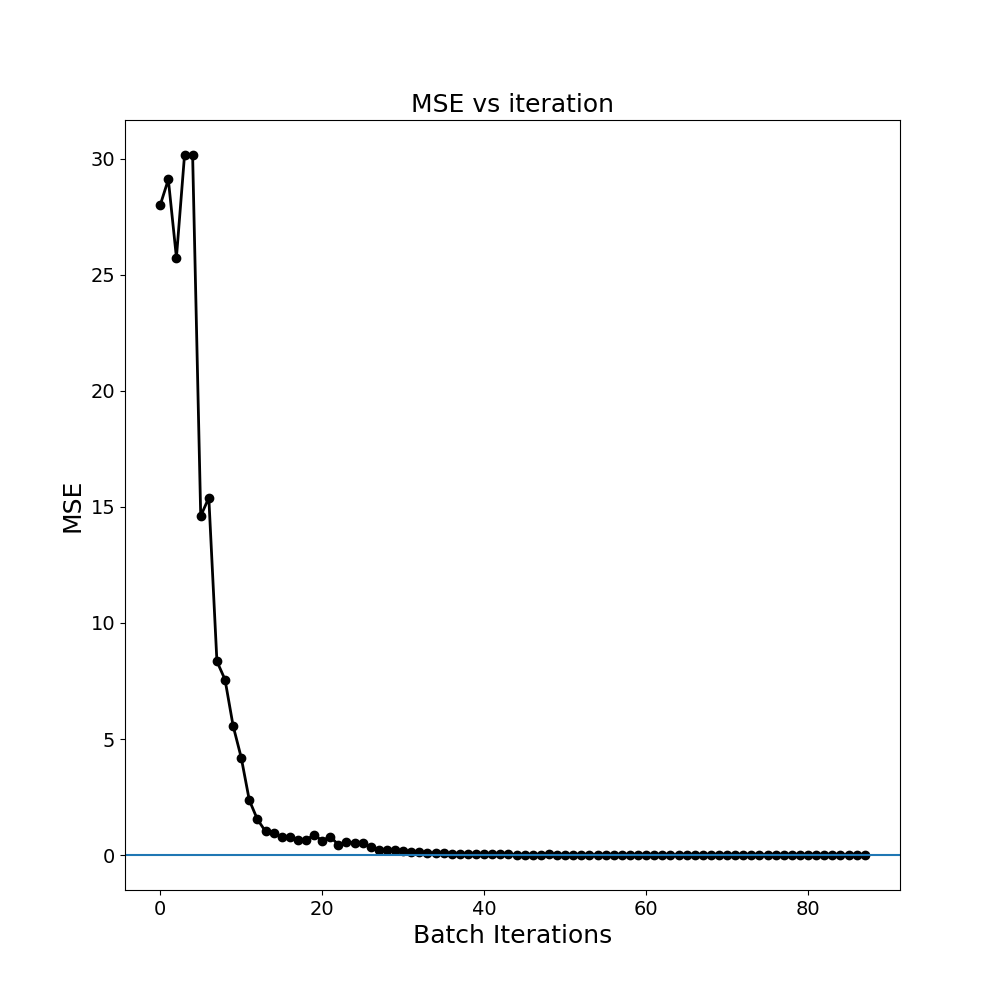

In [9]:
# Creates new figure each time, comment out if you want to use same handle
fig_loss_iter, ax_loss_iter = plt.subplots(figsize=(10, 10));

# Loss values over the parameter path compared to the optimal loss
ax_loss_iter.set_title("MSE vs iteration")
ax_loss_iter.plot(mse_hist, 'ko-', lw=2)
ax_loss_iter.axhline(mse_opt)
ax_loss_iter.set_xlabel("Batch Iterations")
ax_loss_iter.set_ylabel("MSE")

fig_loss_iter;

Similar to the 2D contour parameter trajectory, illustrate this path as a 3D surface:

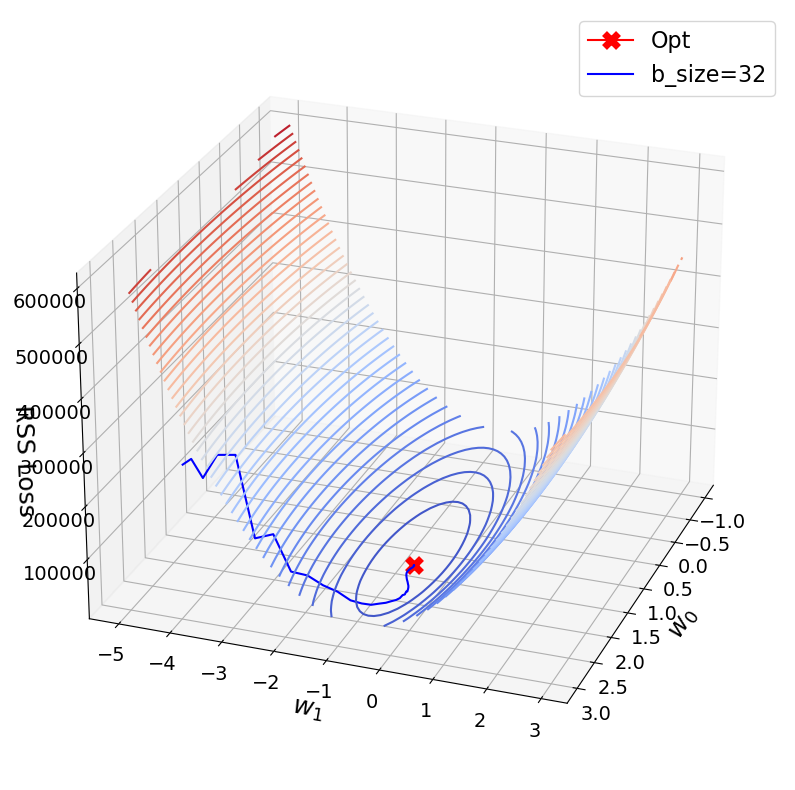

In [10]:
# 3D plot along loss function surface
ax_surface.plot(xs=theta_hist[:, 0], ys=theta_hist[:, 1], zs=N*mse_hist, c='b', label="b_size={}".format(opts['batch_size']))
ax_surface.legend()

fig_surface

Below is an example of how you can use the minimize function of [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) as an alternative optimization approach to GD for LS regression. Observe the <b>speed up</b> in time to compute a solution using the quasi-Newton optimization method over GD. Though the analytical approach for this small dataset, with low $n$ dimensionality ($n=2$), is probably fastest.

In [11]:
from scipy.optimize import minimize


# Need to provide a function handle to the optimizer, which returns the loss objective, e.g. MSE
def func_obj(theta):
    out, _ = lin_reg_loss(theta, X, y)
    return out

# theta_init as before

# Minimize func_obj using L-BFGS-B, a quasi-Newton unconstrained optimization algorithm
start = time.time()
res = minimize(func_obj, theta_init, method='L-BFGS-B')
end = time.time()
# res is the optimization result, has an .x property which is the solution array, e.g. theta*
theta_second = res.x
mse_second = func_obj(theta_second)
print("Second-order Opt Theta: ", theta_second)
print("MSE: ", mse_second)
print("Time elapsed: {}".format(end-start))

Second-order Opt Theta:  [ 1.39970106 -0.70064575]
MSE:  0.009681585691255105
Time elapsed: 0.003964662551879883


Plot RSS trajectory and surface contour for second-order optimization result:

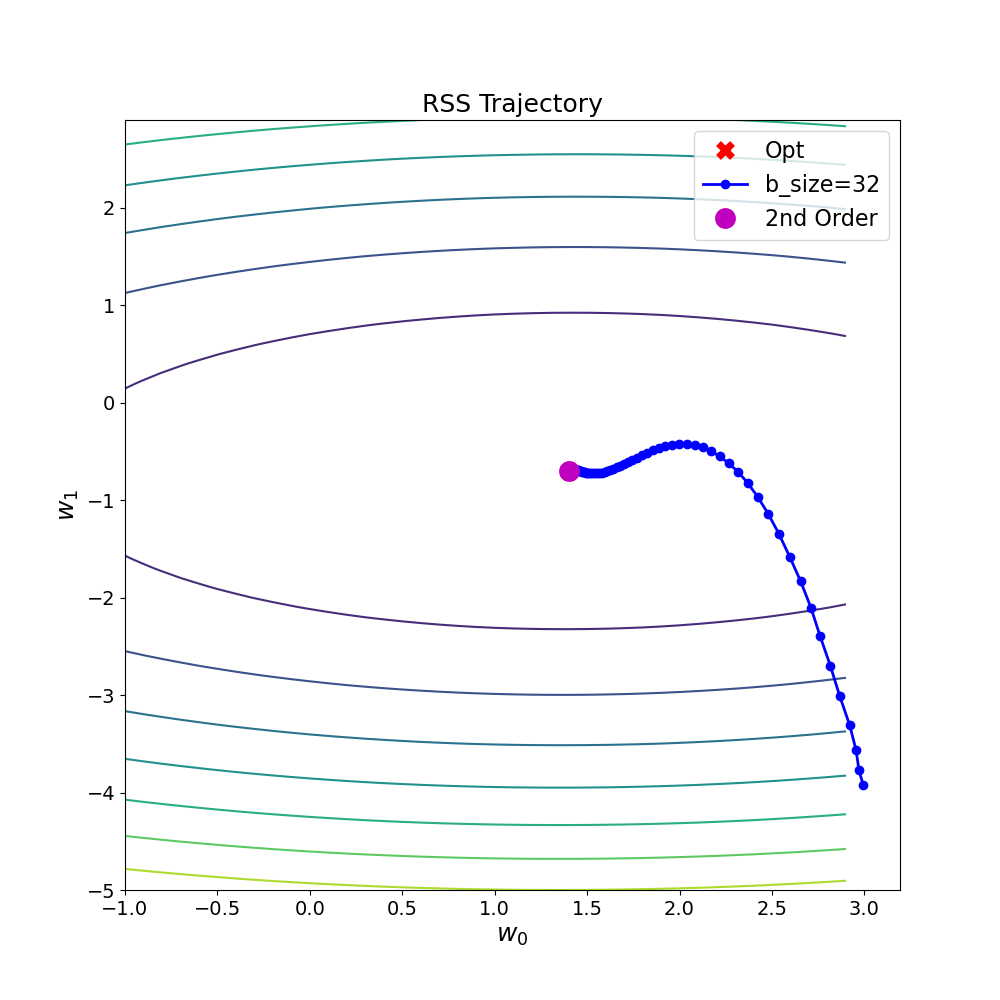

In [12]:
ax_rss.plot(theta_opt[0], theta_opt[1], 'o', color='m', ms=10, mew=5, label="2nd Order")
ax_rss.legend()

fig_rss_traj.show()
fig_rss_traj;

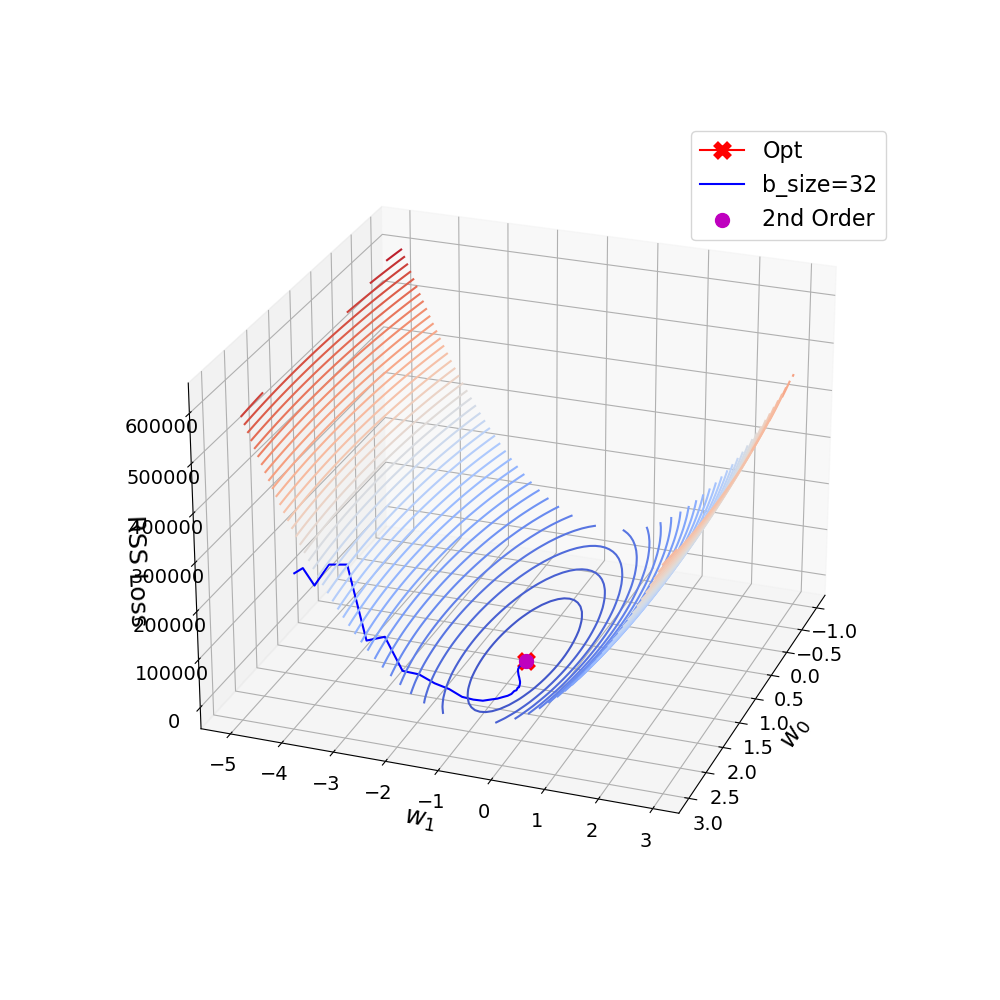

In [13]:
ax_surface.scatter3D(theta_second[0], theta_second[1], N*mse_second, c='m', s=100, label="2nd Order")
ax_surface.legend()

fig_surface.show()
fig_surface;

Finally plot our regression lines using $\boldsymbol{\theta}_{GD}$, $\boldsymbol{\theta}_{opt}$ and $\boldsymbol{\theta}_{second}$:

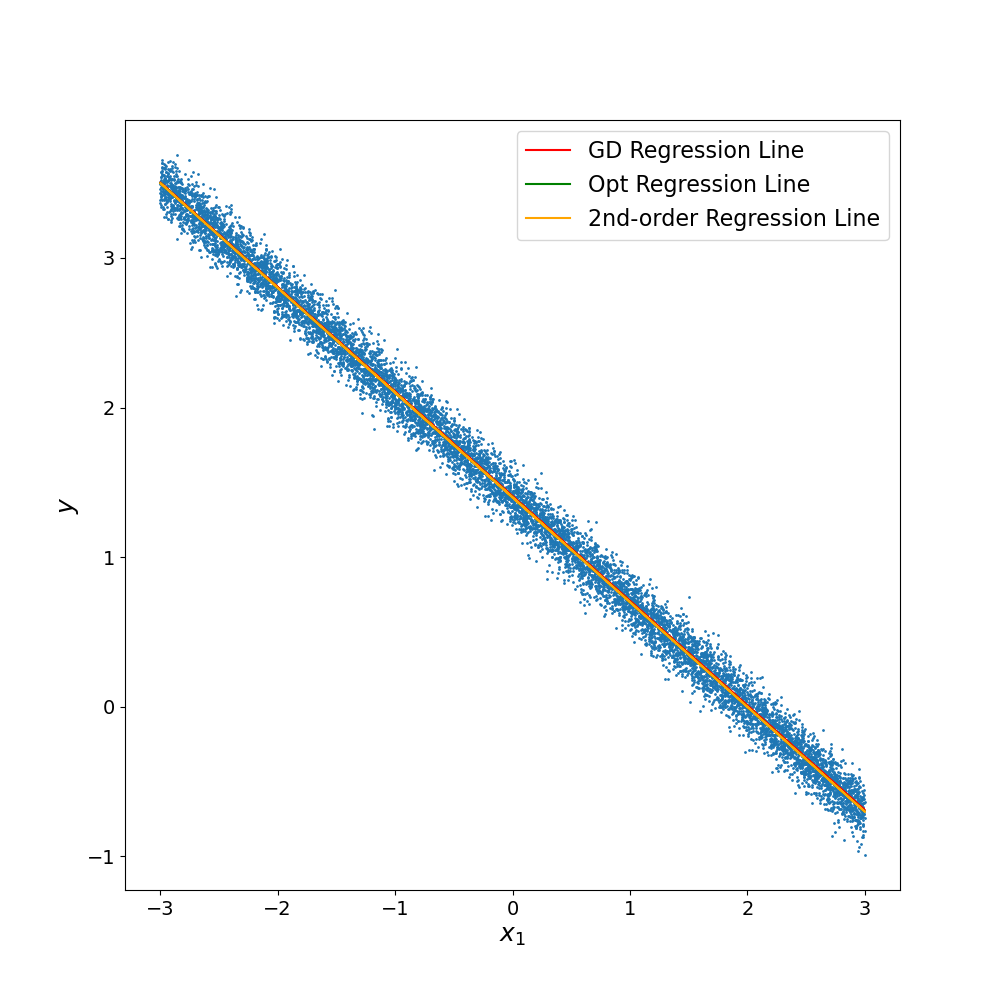

In [14]:
# Predictions with our GD trained theta
gd_predictions = X.dot(theta_gd)
opt_predictions = X.dot(theta_opt)
second_predictions = X.dot(theta_second)

# Plot the learned regression line on our original scatter plot
ax_scatter.plot(X[:,1], gd_predictions, color='red', label="GD Regression Line")
ax_scatter.plot(X[:,1], opt_predictions, color='green', label="Opt Regression Line")
ax_scatter.plot(X[:,1], second_predictions, color='orange', label="2nd-order Regression Line")
ax_scatter.legend()

fig_scatter.show()
fig_scatter;

## References

Code adapted from <i>"lms_demo.ipynb"</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = "probml.ai"<br>
}